# 1. Setup

In [4]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from utils import *

# 2. Load data

## 2.1. Zones

In [6]:
zones = pd.read_parquet('data/zones.parquet').disp()

143,971 rows x 10 cols; Memory: 325.9 MiB


,geoid,level,county,ua_code,city,aland,awater,popu,labor,geometry
,<object>,<category>,<category>,<category>,<category>,<float32>,<float32>,<int32>,<int32>,<object>
0,42007,County,Beaver,69697,Pittsburgh,434.692993,9.329071,164781,84153,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x16\x07...


## 2.2. SES

In [7]:
ses = U.load(DATA / 'ses/ses.parquet').drop_duplicates(subset='geoid').disp()

322,202 rows x 34 cols; Memory: 81.3 MiB


,geoid,scale,popu,house,labor,pop_density,house_density,p_minor,p_poc,p_loweng,...,p_transit,p_bike,p_walk,svi,svi_ses,svi_hh,svi_race,svi_trans,adi_nat,sedi
,<object>,<object>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,...,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>
0,01001,County,58239.0,57692.0,27550.0,97.97068,97.050507,0.18,0.248699,0.002312,...,0.005713,0.002817,0.006904,NaN,NaN,NaN,NaN,NaN,NaN,0.385457


In [8]:
ses_cols = ['popu', 'pop_density', 'p_minor', 'p_poc', 'p_loweng',
            'm_income', 'p_pov', 'p_unemploy', 'p_lowedu', 'p_noinsur',
            'p_disabled', 'p_snglparent', 'p_renter', 'p_noveh']

## 2.3. Access

In [9]:
xs = pd.concat([
    U.filt(U.load(f), kind='Jobs: All', thresh='45', scale='BG')
    .assign(city=f.split('/')[-1].split('.')[0].replace('-', ' ').title())
    for f in tqdm(glob(f'{DATA}/access/access/msa/*.parquet'))
]).astype(D(city=CAT, geoid=CAT))
xs = xs[(xs.measure != 'Contour') & (xs.access != np.inf)].disp() # 4s

  0%|          | 0/50 [00:00<?, ?it/s]

1,785,635 rows x 5 cols; Memory: 149.7 MiB


,measure,mode,geoid,access,city
,<object>,<category>,<category>,<float32>,<category>
11832,Gravity,Bike,130131801031,1312.826416,Atlanta


In [10]:
df = pd.concat([
    U.load(f, filters=[(k, '==', v) for k, v in D(
        scale='BG', measure='Gravity', kind='Jobs: All',
        mode='Drive', thresh='45').items()])
    .assign(city=f.split('/')[-1].split('.')[0].replace('-', ' ').title())
    for f in tqdm(glob(f'{DATA}/access/access/msa/*.parquet'))
]).merge(ses[['geoid', 'popu']]).merge(zones[['geoid', 'aland']]).disp()

  0%|          | 0/50 [00:00<?, ?it/s]

102,707 rows x 10 cols; Memory: 21.0 MiB


,measure,kind,mode,thresh,scale,geoid,access,city,popu,aland
,<object>,<category>,<category>,<category>,<category>,<object>,<float32>,<object>,<float32>,<float32>
0,Gravity,Jobs: All,Drive,45,BG,130131801033,107417.398438,Atlanta,2240.0,4.939298


/tmp/ipykernel_1451741/469027632.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90);


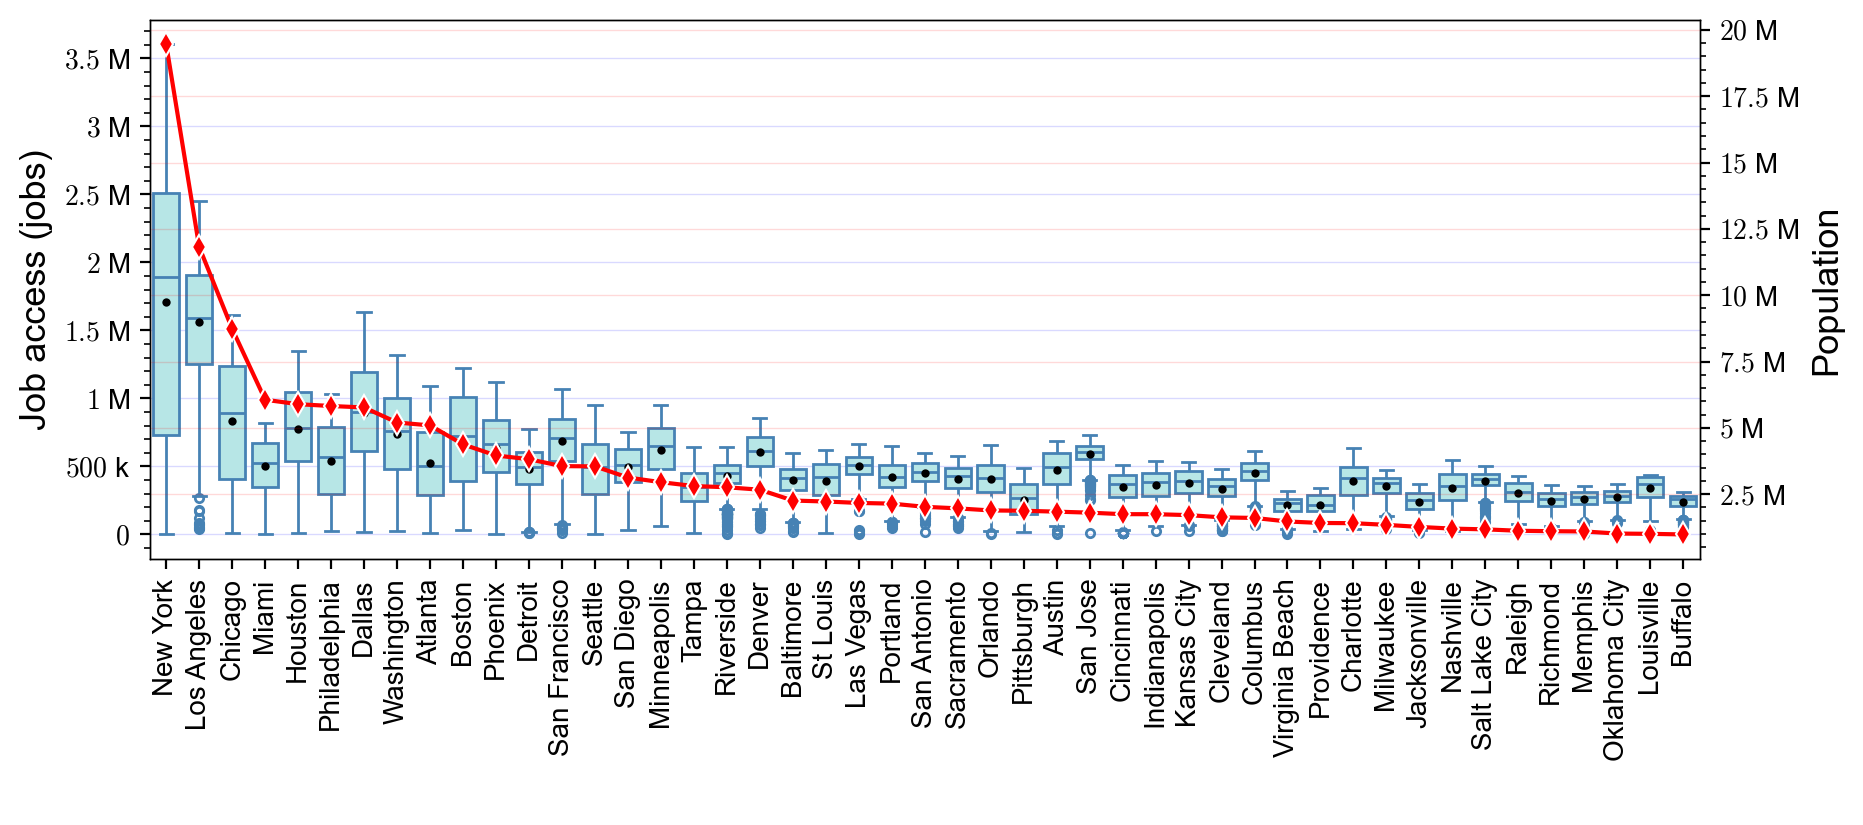

In [11]:
popu = df.groupby('city').popu.sum().sort_values(ascending=0).reset_index()
ax = U.plot(size=(10, 3.5), dpi=200, xminor=0, yeng=1, xlim=(-1, 50),
            xlab=' ', ylab='Job access (jobs)', gridcolor='b')
sns.boxplot(df, x='city', y='access', ax=ax, order=popu.city,
            color='paleturquoise', linecolor='steelblue', fliersize=3, showmeans=True,
            meanprops=D(marker='.', markerfacecolor='k', markeredgecolor='none'))
twin = U.plot(ax.twinx(), ylab='Population', yeng=1, yminor=0, gridcolor='r')
sns.lineplot(popu, x='city', y='popu', ax=twin, color='r', lw=1.5, marker='d')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

/tmp/ipykernel_1451741/3569993270.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90);


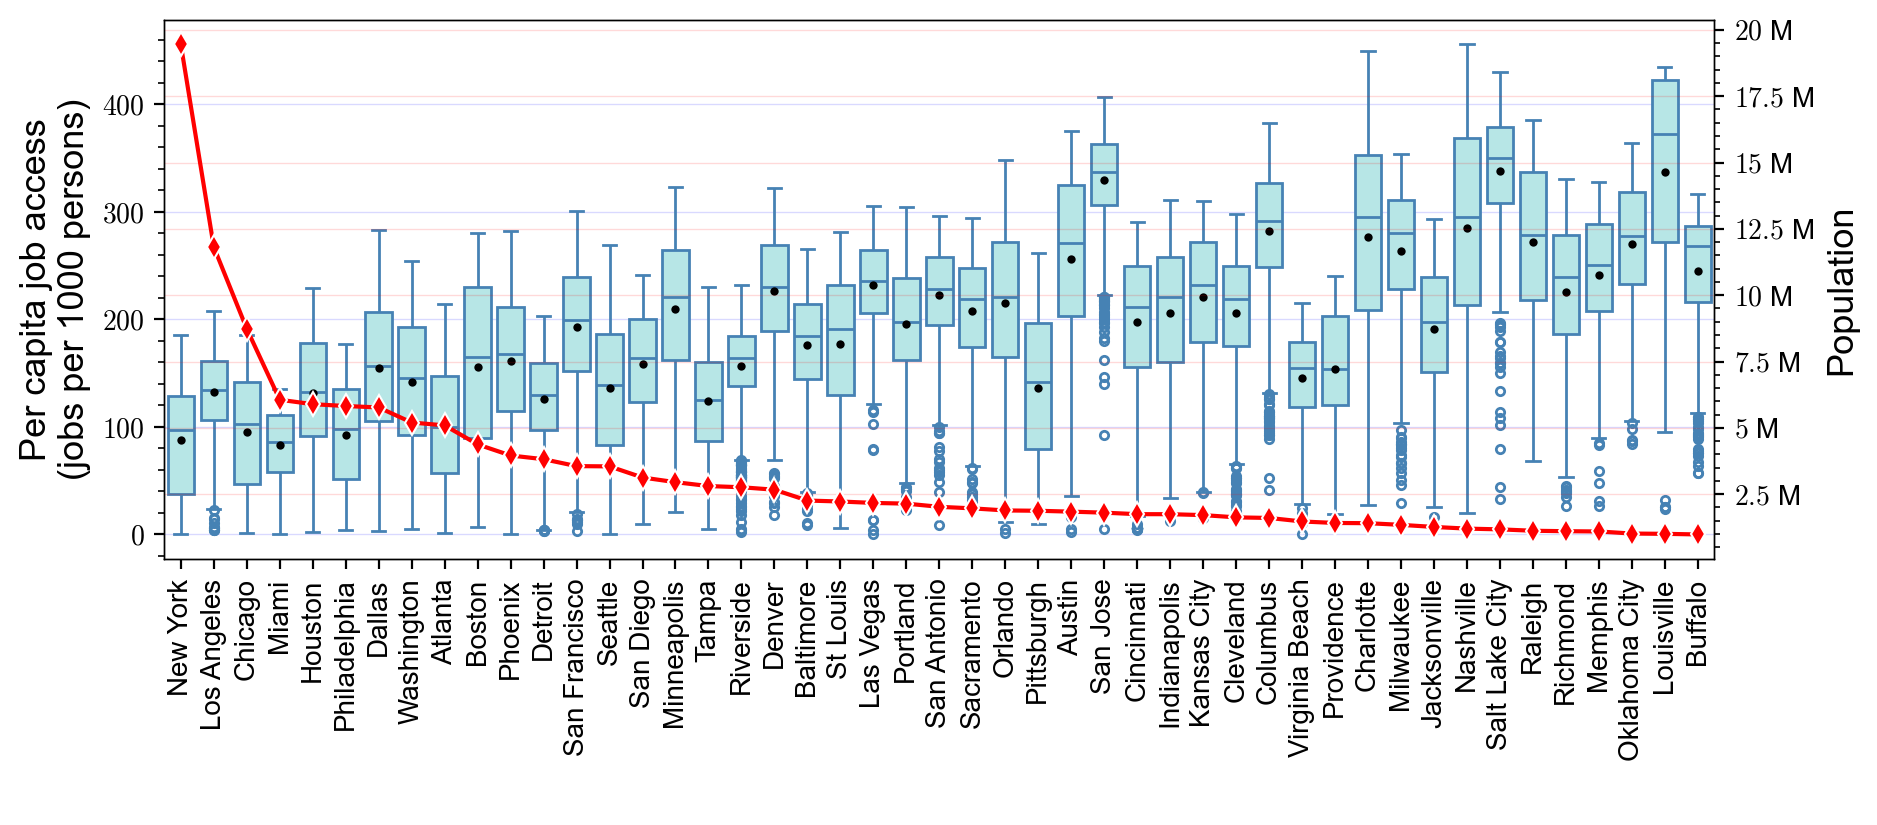

In [12]:
popu = df.groupby('city').popu.sum().sort_values(ascending=0).reset_index()
df2 = df.merge(popu.rename(columns=D(popu='city_popu')))
df2.access /= df2.city_popu / 1000
ax = U.plot(size=(10, 3.5), dpi=200, xminor=0, yeng=1, xlim=(-1, 50), xlab=' ',
            ylab='Per capita job access\n(jobs per 1000 persons)', gridcolor='b')
sns.boxplot(df2, x='city', y='access', ax=ax, order=popu.city,
            color='paleturquoise', linecolor='steelblue', fliersize=3, showmeans=True,
            meanprops=D(marker='.', markerfacecolor='k', markeredgecolor='none'))
twin = U.plot(ax.twinx(), ylab='Population', yeng=1, yminor=0, gridcolor='r')
sns.lineplot(popu, x='city', y='popu', ax=twin, color='r', lw=1.5, marker='d')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

In [13]:
df2 = df.groupby('city')[['popu', 'aland']].sum().reset_index()
df2['pop_density'] = df2.popu / df2.aland
df2 = df2.sort_values('pop_density')

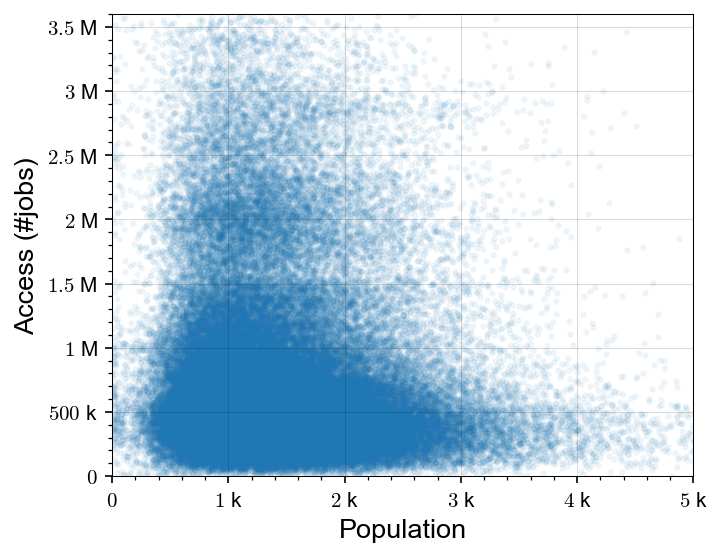

In [14]:
df2 = df.drop(columns='popu').merge(df.groupby('city').popu.sum(), on='city')
ax = U.plot(size=(5, 4), dpi=150, xlab='Population', xeng=1,
            ylab='Access (#jobs)', yeng=1, xlim=(0, 5e3), ylim=(0, 3.6e6))
ax.scatter(df.popu, df.access, s=5, alpha=0.05);

In [27]:
hpms = U.load(
    DATA / 'traffic/hpms/hpms2016.parquet',
    filters=[('urban_code', '!=', x) for x in [0, 99998, 99999]],
    columns='aadt access_control f_system speed_limit urban_code geometry'.split())
hpms = hpms.merge(zones[['city', 'urba_code']].drop_duplicates()
                  .rename(columns=D(urba_code='urban_code'))
                  .astype(D(urban_code=I32))).disp() # 21s

3,004,379 rows x 10 cols; Memory: 292.6 MiB; <Projected CRS: EPSG:3857>


,state_code,aadt,access_control,f_system,facility_type,speed_limit,urban_code,length,geometry,city
,<int32>,<int32>,<int16>,<int16>,<int16>,<int16>,<int32>,<float64>,<geometry>,<object>
0,37,1500,3,5,2,55,73261,199.063769,"MULTILINESTRING ((-8719919.3148 4270524.3939, ...",Raleigh


# 3. Visualize

## 3.2. Access distribution

In [11]:
bg = (U.filt(zones, scale='BG').set_index('geoid')
      .merge(ses, on='geoid').select_dtypes(F32)).disp()

105,189 rows x 16 cols; Memory: 13.3 MiB


,aland,awater,popu,pop_density,p_minor,p_poc,p_loweng,m_income,p_pov,p_unemploy,p_lowedu,p_noinsur,p_disabled,p_snglparent,p_renter,p_noveh
geoid,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>
040130101022,4.577659,0.000319,1811.0,395.617004,0.062949,0.102706,0.019509,0.160671,0.062949,0.0,0.128509,0.06571,0.192453,0.0,0.0381,0.0


In [12]:
cnty = bg.assign(geoid=bg.index.str[:5]).set_index('geoid')
for col in cnty.columns[3:]:
    cnty[col] *= cnty.popu
cnty = cnty.groupby('geoid').sum()
for col in cnty.columns[3:]:
    cnty[col] /= cnty.popu
cnty.disp();

311 rows x 16 cols; Memory: 0.0 MiB


,aland,awater,popu,pop_density,p_minor,p_poc,p_loweng,m_income,p_pov,p_unemploy,p_lowedu,p_noinsur,p_disabled,p_snglparent,p_renter,p_noveh
geoid,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>
04013,1570.929321,4.695071,3800913.0,6328.290039,0.172443,0.284481,0.042616,0.227854,0.123329,0.050097,0.296631,0.107409,0.233351,0.224211,0.356641,0.051897


In [13]:
city = zones[['geoid', 'city']].merge(bg, on='geoid').set_index('city').drop(columns='geoid')
for col in city.columns[3:]:
    city[col] *= city.popu
city = city.groupby('city').sum()
for col in city.columns[3:]:
    city[col] /= city.popu
city.disp();

50 rows x 16 cols; Memory: 0.0 MiB


,aland,awater,popu,pop_density,p_minor,p_poc,p_loweng,m_income,p_pov,p_unemploy,p_lowedu,p_noinsur,p_disabled,p_snglparent,p_renter,p_noveh
city,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>
Atlanta,3159.457031,58.577038,5091169.0,3812.01123,0.182458,0.548186,0.038006,0.225994,0.112125,0.054088,0.284084,0.127125,0.208018,0.257782,0.348319,0.053107


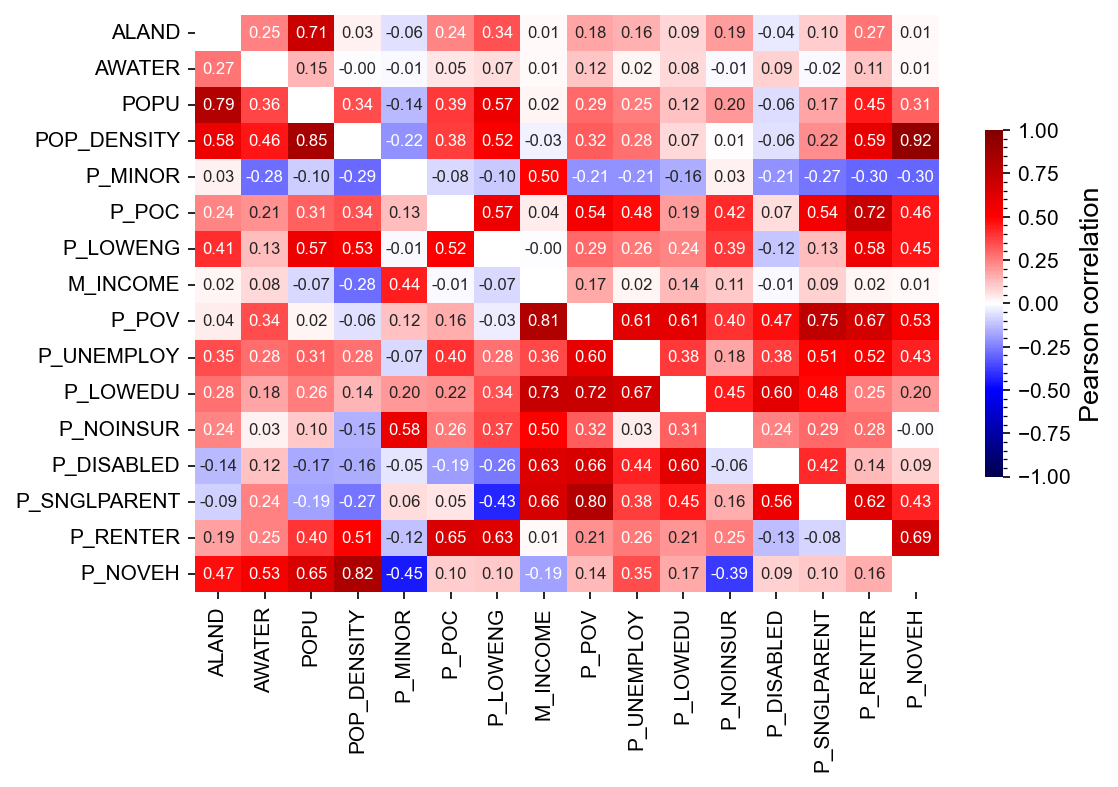

In [14]:
corr = np.triu(cnty.corr(), 1) + np.tril(city.corr(), -1)
np.fill_diagonal(corr, np.nan)
cols = bg.columns.str.upper()
corr = Pdf(corr, columns=cols, index=cols)
ax = U.plot(size=(8, 5), dpi=150, gridcolor='none', xminor=0, yminor=0)
sns.heatmap(corr, ax=ax, cmap='seismic', vmin=-1, vmax=1,
            annot=True, fmt='.2f', annot_kws=D(fontsize=8),
            cbar_kws=D(shrink=0.6, label='Pearson correlation'));

## 3.3. Normalized gravity access
Gravity access per person

In [15]:
xs2 = (xs.drop(columns='city').merge(zones[['geoid', 'county', 'city']])
       .merge(ses[['popu']], on='geoid'))
df = xs2[xs2.measure == 'Gravity']
xs2 = pd.concat([xs2, df.assign(access=df.access / df.popu, measure='Norm Gravity')])
xs2 = xs2.astype(D(measure=str, geoid=str, county=str, city=str)).disp()

969,334 rows x 8 cols; Memory: 260.5 MiB


,measure,mode,geoid,access,purpose,county,city,popu
,<object>,<category>,<object>,<float32>,<category>,<object>,<object>,<float32>
0,Gravity,Bike,130131801033,1190.845581,NaN,Barrow,Atlanta,2240.0


In [16]:
xs3 = xs2[xs2.measure == 'Gravity'].groupby('county')[['access', 'popu']].sum()
xs3.access /= xs3.popu
xs3 = xs3[['access']].merge(zones[['county', 'geoid']].merge(cnty, on='geoid').drop(columns='geoid').set_index('county'), on='county')
xs3

,access,aland,awater,popu,pop_density,p_minor,p_poc,p_loweng,m_income,p_pov,p_unemploy,p_lowedu,p_noinsur,p_disabled,p_snglparent,p_renter,p_noveh
county,,,,,,,,,,,,,,,,,
Adams,109.045212,273.965057,8.382766,501068.0,6316.289062,0.194816,0.293242,0.057737,0.234877,0.097348,0.046680,0.387127,0.106221,0.246395,0.201992,0.305876,0.042114
Alexandria,271.194275,14.697650,0.412224,158185.0,19724.638672,0.114056,0.412428,0.048629,0.185540,0.095749,0.033130,0.175053,0.091208,0.136252,0.222388,0.568032,0.108555
Allegheny,100.244705,711.731018,13.520166,1243703.0,5108.986816,0.137068,0.216093,0.008561,0.219641,0.112732,0.052101,0.275561,0.038942,0.245275,0.247425,0.299575,0.118483
Anne Arundel,56.909092,300.644531,43.921951,559481.0,4610.302246,0.165267,0.314164,0.014790,0.204754,0.056599,0.041292,0.258226,0.044421,0.210682,0.184527,0.244669,0.034938
Anoka,126.737068,197.273270,11.674976,314531.0,3292.374023,0.178714,0.210189,0.022130,0.219563,0.061057,0.039533,0.290416,0.043472,0.210849,0.191777,0.191881,0.043695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Williamson,61.391373,211.667984,0.798308,171809.0,1651.153564,0.205280,0.163525,0.008809,0.187748,0.037262,0.025269,0.123979,0.041255,0.157484,0.120807,0.168773,0.020914
Williamson,61.391373,418.008453,4.511345,538875.0,3726.252686,0.194494,0.286168,0.024975,0.212894,0.060810,0.044805,0.198474,0.091326,0.205168,0.161926,0.298441,0.020490
Wright,34.423775,67.306068,4.739432,47868.0,1593.380737,0.239826,0.097811,0.003711,0.214331,0.021212,0.016740,0.220285,0.030731,0.142319,0.084887,0.094879,0.019992


In [17]:
X, y = xs3.drop(columns='access'), xs3['access']
reg = LinearRegression().fit(X, y)
reg.coef_

array([-2.2728058e-02,  1.7584908e-01,  2.4943452e-05,  8.6206514e-03,
        3.9448717e+00,  9.6327953e+00,  2.3557732e+00, -8.1344595e+00,
       -1.9329765e+01, -5.1102695e+00, -3.8054035e+01, -2.0650413e+00,
       -2.2347775e+01, -3.0719032e+01, -2.1590040e+01, -1.2075146e+01],
      dtype=float32)

In [18]:
sm.add_constant(X)
model = sm.OLS(y, X)
res = model.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                 access   R-squared (uncentered):                   0.878
Model:                            OLS   Adj. R-squared (uncentered):              0.876
Method:                 Least Squares   F-statistic:                              354.6
Date:                Wed, 11 Sep 2024   Prob (F-statistic):                    8.50e-89
Time:                        15:29:41   Log-Likelihood:                         -1028.3
No. Observations:                 201   AIC:                                      2065.
Df Residuals:                     197   BIC:                                      2078.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [19]:
model = sm.OLS(y, X.drop(columns='popu'))
res = model.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                 access   R-squared (uncentered):                   0.871
Model:                            OLS   Adj. R-squared (uncentered):              0.862
Method:                 Least Squares   F-statistic:                              97.78
Date:                Wed, 11 Sep 2024   Prob (F-statistic):                    3.13e-76
Time:                        15:29:41   Log-Likelihood:                         -1033.8
No. Observations:                 201   AIC:                                      2094.
Df Residuals:                     188   BIC:                                      2137.
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [ ]:
ax = U.plot(size=(6, 6), dpi=150)
U.maplot(U.filt(zones, city='New York', scale='BG')
         .merge(ses, on='geoid'),
         'pop_density', ax=ax, cmap='Reds', vmax=120_000)
(U.filt(zones, city='New York', scale='County')
 .plot(ax=ax, fc='none', ec='k', lw=0.5)); # 3s

$$a_C = \frac{1}{\sum_i p_i} \left[\sum_i p_i \sum_{j\in C(i)} \frac{o_j w_{ij}}{\sum_{j\in C(i)} p_k w_{kj}} \right] $$

In [ ]:
df = (U.filt(xs, measure='Competition', mode='Drive')
      .merge(zones[['geoid', 'popu']])
      .assign(access=lambda df: df.access * df.popu)
      .groupby('city')[['popu', 'access']].sum().reset_index()
      .assign(access=lambda df: df.access / df.popu).dropna()
      .sort_values('access', ascending=False))
ax = U.plot(size=(9, 2.5), dpi=150, xminor=False,
            ylab='Competition access\n(jobs/person)')
df.plot.bar(x='city', y='access', ax=ax)
ax.set_xlabel('');

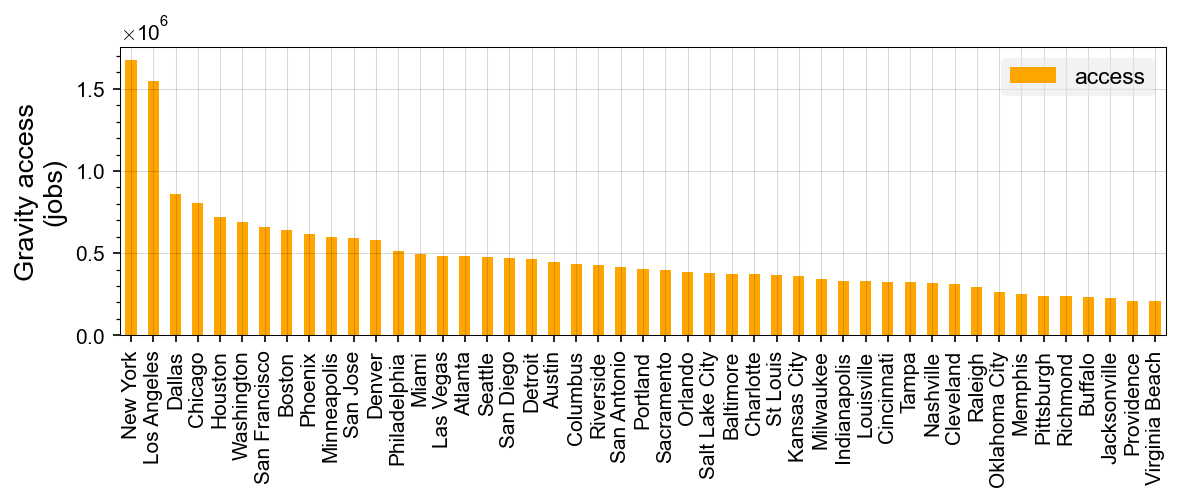

In [ ]:
df = (U.filt(xs, measure='Gravity', mode='Drive')
      .merge(zones[['geoid', 'popu']])
      .assign(access=lambda df: df.access * df.popu)
      .groupby('city')[['popu', 'access']].sum().reset_index()
      .assign(access=lambda df: df.access / df.popu).dropna()
      .sort_values('access', ascending=False))
ax = U.plot(size=(9, 2.5), dpi=150, xminor=False,
            ylab='Gravity access\n(jobs)')
df.plot.bar(x='city', y='access', ax=ax, color='orange')
ax.set_xlabel('');

$$a_G = \frac{\sum_{j\in C(i)} o_j w_{ij}}{\sum_i p_i} $$

- $p_i$: population of zone $i$
- $C(i)$: catchment of $i$ defined by time threshold
- $o_j$: no. of opportunities in zone $j$
- $w_{ij}$: modal impedance weight b/w zones $i$ and $j$

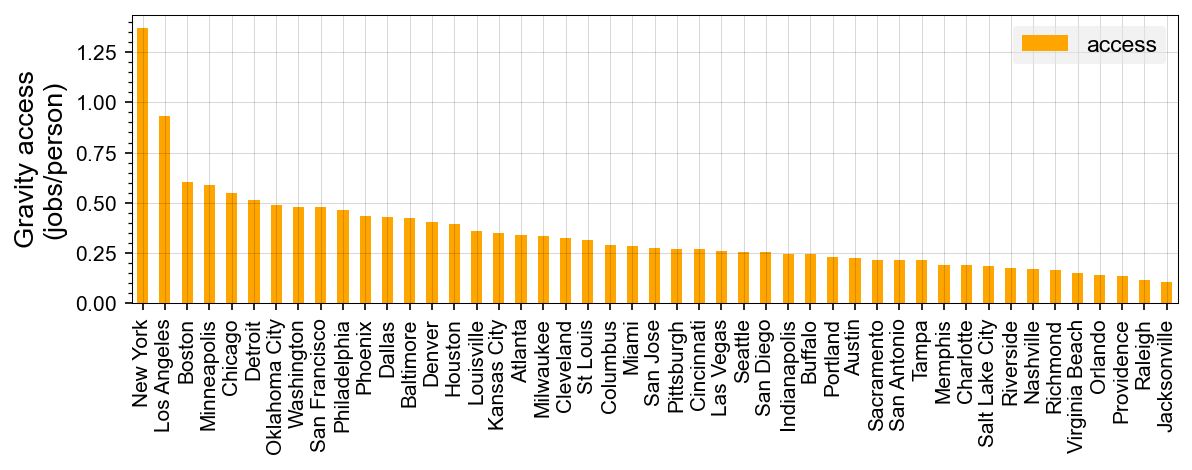

In [ ]:
df = (U.filt(xs2, measure='Norm Gravity', mode='Drive')
      .groupby('city')[['popu', 'access']].sum().reset_index()
      .assign(access=lambda df: df.access / df.popu).dropna()
      .sort_values('access', ascending=False))
ax = U.plot(size=(9, 2.5), dpi=150, xminor=False,
            ylab='Gravity access\n(jobs/person)')
df.plot.bar(x='city', y='access', ax=ax, color='orange')
ax.set_xlabel('');

In [ ]:
df = (U.filt(xs, measure='Gravity', mode='Drive')
      .merge(zones[['geoid', 'county', 'popu']])
    #   .assign(access=lambda df: df.access * df.popu)
      .groupby(['city', 'county'])[['popu', 'access']].sum().reset_index()
      .assign(access=lambda df: df.access / df.popu).dropna()
      .sort_values('access', ascending=False))
# ax = U.plot(size=(9, 2.5), dpi=150, xminor=False,
#             ylab='Gravity access\n(jobs)')
# df.plot.bar(x='city', y='access', ax=ax, color='tomato')
# ax.set_xlabel('');
df

,city,county,popu,access
24366,Detroit,Livingston,33.0,3273.035156
51571,New York,New York,1669127.0,2171.437256
50626,New York,Bronx,1468262.0,1833.027100
51297,New York,Kings,2712360.0,1766.641968
51754,New York,Queens,2393104.0,1758.729736
...,...,...,...,...
74886,San Antonio,Medina,3378.0,29.023897
87080,Virginia Beach,Gloucester,14463.0,23.482513
24324,Detroit,Lapeer,1747.0,16.871445
35117,Kansas City,Lafayette,1584.0,16.411362
